# Сборный проект №2

**Контекст:** Cтартап, который продаёт продукты питания. Необхожимо разобраться, как ведут себя пользователи мобильного приложения.

**Задачи:** Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

**Описание данных:**
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Содержание:**
1. [Загрузка данных и изучение общей информации](#chapter1)
2. [Предобработка данных](#chapter2)
3. [Изучим и проверим данные](#chapter3)
4. [Изучим воронку событий](#chapter4)
5. [Изучим результаты эксперимента](#chapter5)
6. [Общий вывод](#chapter6)

In [1]:
import pandas as pd
import datetime as dt 
import numpy as np 
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st 

<a id="chapter1"></a>

###  Загрузка данных и изучение общей информации

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
def first_look (data):
    print('---------Первые 5 строк-----------')
    display(data.head())
    print('---------Основная информация о датафрейме---------------\n')
    display(data.info())
    print('---------Пропуски-----------\n')
    display(data.isna().sum())
    print('\n---------Явные дубликаты-----------\n')
    if data.duplicated().sum() > 0:
        print('Явных дубликатов:', data.duplicated().sum())
    else:
        print('Явных дубликатов НЕТ')
first_look (logs)

---------Первые 5 строк-----------


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


---------Основная информация о датафрейме---------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

---------Пропуски-----------



EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


---------Явные дубликаты-----------

Явных дубликатов: 413


**Общий вывод по разделу**
- В данных нет пропусков;
- Необходимо изменить названия столбцов;
- Столбц EventTimestamp необходио привести к формату дат;
- Необходимо удалить явные дубликаты.

<a id="chapter2"></a>

### Предобработка данных
**2.1 Изменим названия колонок**

In [3]:
logs = logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp',\
                            'ExpId': 'exp_id'})
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**2.2 Удалим явные дубликаты**

In [4]:
logs = logs.drop_duplicates().reset_index(drop=True)

display(logs.duplicated().sum())
logs.head()

0

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**2.3 Изменим типа данных стобца event_timestamp и добавим еще одну колонку с датами**

In [5]:
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['event_timestamp'].dt.date)
logs.head()

,event_name,user_id,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


**Общий вывод по разделу:**

- Изменили названия столбцов;
- Удалили явные дубликаты;
- Изменили тип данных стобца event_timestamp; 
- Добавили еще одну колонку с датами date.

<a id="chapter3"></a>

###  Изучим и проверим данные

**3.1 Узнаем сколько всего событий в логе**

In [7]:
len_event_name = len(logs['event_name'])
print(f'Всего событий в логе: {len_event_name}')

Всего событий в логе: 243713


**3.2 Узнаем сколько всего пользователей в логе**

In [8]:
nunique_user_id = logs['user_id'].nunique()
print(f'Всего пользователей в логе: {nunique_user_id}')

Всего пользователей в логе: 7551


**3.3 Узнаем сколько в среднем событий приходится на пользователя**

In [9]:
median_event_name = logs.groupby('user_id')['event_name'].agg('count').median()
print(f'Среднее количество событий на пользователя: {median_event_name}')

Среднее количество событий на пользователя: 20.0


**3.4 Найдем период за который располагаем данными**

In [10]:
max_date = logs['date'].max()
print(f'Максимальная дата: {max_date}')

Максимальная дата: 2019-08-07 00:00:00


In [11]:
min_date = logs['date'].min()
print(f'Минимальная дата: {min_date}')

Минимальная дата: 2019-07-25 00:00:00


**3.4.1 Построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп**

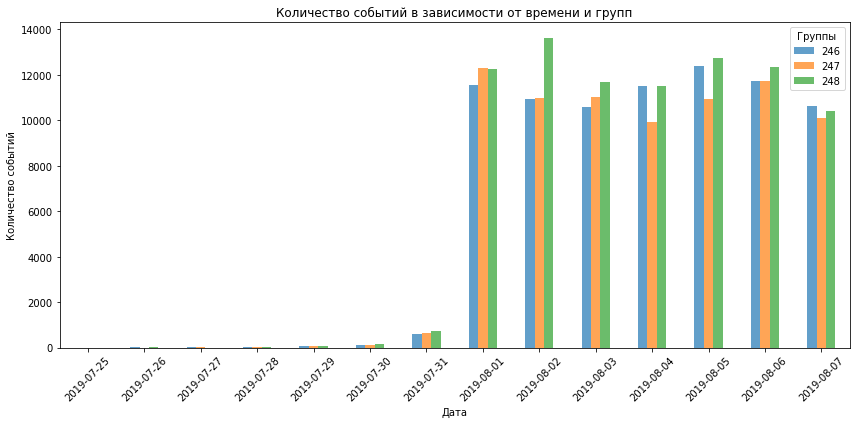

In [12]:
# Подсчет количества событий по датам и группам
grouped_data = logs.groupby(['date', 'exp_id']).size().reset_index(name='event_count')

# Поворот столбца даты для удобства
grouped_data['date'] = pd.to_datetime(grouped_data['date']).dt.date

# Уникальные значения для групп
unique_exp_ids = grouped_data['exp_id'].unique()

# Подготовка данных для группового барплота
pivot_data = grouped_data.pivot(index='date', columns='exp_id', values='event_count').fillna(0)

# Построение группового барплота
pivot_data.plot(kind='bar', figsize=(12, 6), alpha=0.7)

# Настройка графика
plt.title('Количество событий в зависимости от времени и групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.legend(title='Группы')
plt.tight_layout()  # Для оптимального отображения
plt.show()

**Вывод** По данному графику мы видим, что "полные" данные начинаютсяя с 2019-08-01, до этой даты отбросим данные.

In [13]:
dt_logs = logs.query('date >= "2019-08-01"')

**3.5 Посмотрим много ли событий и пользователей мы потеряли, отбросив старые данные**

In [14]:
fraction = round((100 * (len(logs) - len(dt_logs))/len_event_name), 1)
print(f'Доля отброшенных событий и пользователей: {fraction}%')

Доля отброшенных событий и пользователей: 1.2%


**Вывод:** Доля отброшенных даных составила всего 1.2%, ничего критичного.

**3.6 Проверим, что у нас есть пользователи из всех трёх экспериментальных групп**

In [15]:
dt_logs.pivot_table(index = 'exp_id', values = 'user_id', aggfunc = 'count')

,user_id
exp_id,
246,79302
247,77022
248,84563


**Вывод:** Все пользователи на месте.

**Общий вывод по разделу:**
- Всего событий в логе: 243713;
- Всего пользователей в логе: 7551;
- Среднее количество событий на пользователя: 20.0;
- Период за который располагаем данными: с 2019-07-25 по 2019-08-07;
- Отбросили "неполные" данные до 2019-08-01;
- Доля отброшенных данных: 1.2%.

<a id="chapter4"></a> 

###  Изучим воронку событий

**4.1 Посмотрим, какие события есть в логах, как часто они встречаются**

In [16]:
dt_logs_event = (
    dt_logs.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'count')
    .sort_values(by = 'user_id', ascending=False)
    .rename(columns={'user_id': 'count'})
)

dt_logs_event['event_percent'] = (
    (dt_logs_event['count'] / dt_logs_event['count'].sum() * 100)
    .map(lambda x: f'{x:.2f}%')
)

dt_logs_event

,count,event_percent
event_name,,
MainScreenAppear,117328,48.71%
OffersScreenAppear,46333,19.23%
CartScreenAppear,42303,17.56%
PaymentScreenSuccessful,33918,14.08%
Tutorial,1005,0.42%


**Вывод:** Чаще всего встречается событие MainScreenAppear - 48.71%, а меньше всего Tutorial - 0.42%.

**4.2 Посчитаем, сколько пользователей совершали каждое из этих событий**

In [17]:
dt_logs_event_user = (
    dt_logs.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
    .sort_values(by = 'user_id', ascending=False)
    .rename(columns={'user_id': 'count'})
)

dt_logs_event_user['event_percent'] = (
    (dt_logs_event_user['count'] / dt_logs['user_id'].nunique()*100)
    .map(lambda x: f'{x:.2f}%')
)

dt_logs_event_user

,count,event_percent
event_name,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%
Tutorial,840,11.15%


**Вывод:** Больше всего пользователей - 98.47% совершали событие MainScreenAppear, а меньше всего Tutorial - 11.15%.	

**4.3 Предположим, в каком порядке происходят события**

Выстраиваем события в последовательную цепочку. Предположим, что пользователь:

1. Открывает главную страницу приложения (MainScreenAppear);
2. В каталоге выбирает товары (OffersScreenAppear);
3. Кладёт товар в корзину (CartScreenAppear);
4. Оплачивает (PaymentScreenSuccessful).

руководство в эту цепочку не входит(Tutorial)

**4.4 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки и посмотрим на каком шаге теряем больше всего пользователей** 

In [18]:
user_event = (dt_logs
                .query('event_name != "Tutorial"')
                .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
                .sort_values(by = 'user_id', ascending = False)
)

#добавим столбец со смещенными значениями количества пользователей методом shift
#недостающее значение заполним первым значением столбца параметром fill_value
user_event['shift'] = user_event['user_id'].shift(1, fill_value = user_event['user_id'].loc[user_event.index[0]])

user_event['conversion'] = ((user_event['user_id']/user_event['shift']*100)
                           .map(lambda x: f'{x:.2f}%')
)

user_event = user_event[['user_id', 'conversion']]
user_event = user_event.reset_index()
user_event

,event_name,user_id,conversion
0,MainScreenAppear,7419,100.00%
1,OffersScreenAppear,4593,61.91%
2,CartScreenAppear,3734,81.30%
3,PaymentScreenSuccessful,3539,94.78%


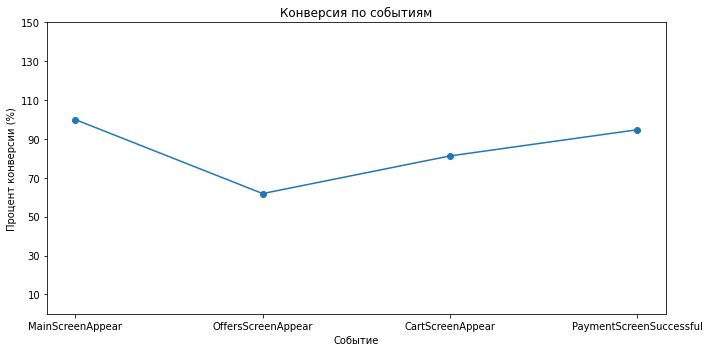

In [19]:
user_event['conversion'] = user_event['conversion'].replace({'%': '', '': None}, regex=True).astype(float)

plt.figure(figsize=(10, 5))
plt.plot(user_event['event_name'], user_event['conversion'], marker='o', linestyle='-')

# Настройки графика
plt.title('Конверсия по событиям')
plt.xlabel('Событие')
plt.ylabel('Процент конверсии (%)')
plt.grid(True)
plt.ylim(0,100)

# Настраиваем метки оси Y для отображения % от 100 до 0
percent_values = list(range(150, -1, -20))  # Проценты от 150 до 0 с шагом 20
plt.yticks(percent_values)  # Устанавливаем значения меток

# Показываем график
plt.grid()
plt.tight_layout()
plt.show()

**Вывод:** Онлайн-магазины и приложения стараются сделать процесс покупки как можно более простым и удобным для пользователя. Есть шанс, что в приложении можно добавить товар в корзину без просмотра каталога: например, возле карточки товара есть кнопка «Добавить в корзину». Возможно поэтому на событии OffersScreenAppear заметен резкий провал конверсии.

**4.5 Посчитаем какая доля пользователей доходит от первого события до оплаты**

In [20]:
print(f"Доля пользователей прошедших от первого события до оплаты {user_event['user_id'].loc[user_event.index[-1]]/user_event['user_id'].loc[user_event.index[0]]:.2%}")

Доля пользователей прошедших от первого события до оплаты 47.70%


**Общий вывод по разделу:**
- Посмотрили, какие события есть в логах, и как часто они встречаются: MainScreenAppear - 48.71%, а меньше всего Tutorial - 0.42%;
- Нашли, что больше всего пользователей - 98.47% совершали событие MainScreenAppear, а меньше всего Tutorial - 11.15%;
- Предположили в каком порядке происходят события: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful, а Tutoria в эту цепочку не входит, так как это руководство;
- По воронке событий посчитали какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем): 100% - 61.91% - 81.30% - 94.78%;
- Выяснили на каком шаге теряется больше всего пользователей. На событии OffersScreenAppear заметен резкий провал конверсии, предположили, что это из-за возможности добавления товара в корзину без просмотра каталога: например, возле карточки товара есть кнопка «Добавить в корзину»;
- Посчитали долю пользователей прошедших от первого события до оплаты, она составила 47.70%.

<a id="chapter5"></a>

### Изучим результаты эксперимента
**5.1 Посмотрим сколько пользователей в каждой экспериментальной группе**

In [21]:
dt_logs.groupby('exp_id').agg(count=('user_id', 'nunique'))

,count
exp_id,
246,2484
247,2513
248,2537


**Проверим наличие пользователей, которые присутствуют одновременно в группах 246, 247, 248**

In [22]:
# Получаем уникальные userid для группы 246
userid_246 = logs['user_id'].loc[logs['exp_id'] == '246'].unique()

# Получаем уникальные userid для группы 247
userid_247 = logs['user_id'].loc[logs['exp_id'] == '247'].unique()

# Получаем уникальные userid для группы 248
userid_248 = logs['user_id'].loc[logs['exp_id'] == '248'].unique()

# Преобразуем в множества для удобной работы
set_246 = set(userid_246)
set_247 = set(userid_247)
set_248 = set(userid_248)

# Находим пересечение
intersection_users = set_246.intersection(set_247, set_248)

# Подсчитываем количество пользователей в пересечении
count_common_users = len(intersection_users)

print(f'Количество пользователей, присутствующих в группах 246, 247 и 248: {count_common_users}')

Количество пользователей, присутствующих в группах 246, 247 и 248: 0


**Вывод:** Разница в экспериментальных группах минимальная и пересекающихся пользователей в группах нет.

**5.2 Проверим, находят ли статистические критерии разницу между выборками 246 и 247**

**Сформулируем следующие гипотезы:**

**Нулевая гипотеза (H0)**

Для Shapiro-Wilk теста:
- Группа 246 имеет нормальное распределение.
- Группа 247 имеет нормальное распределение.

Для сравнения групп:
Нет статистически значимых различий в значениях метрики между группами 246 и 247 (различия в среднем значении равны нулю).

**Альтернативная гипотеза (H1)**

Для Shapiro-Wilk теста:
- Группа 246 не имеет нормального распределения.
- Группа 247 не имеет нормального распределения.

Для сравнения групп:
Имеются статистически значимые различия в значениях метрики между группами 246 и 247 (различия в среднем значении не равны нулю).

In [23]:
# Фильтрация данных для контрольных групп
control_group_246 = dt_logs[dt_logs['exp_id'] == 246]
control_group_247 = dt_logs[dt_logs['exp_id'] == 247]

# Подсчёт количества событий для каждой группы
event_counts_246 = control_group_246.groupby('event_name')['user_id'].nunique()
event_counts_247 = control_group_247.groupby('event_name')['user_id'].nunique()

# Объединяем данные в один DataFrame для анализа
combined_data = pd.DataFrame({
    'group_246': event_counts_246,
    'group_247': event_counts_247
}).dropna()

# Проверка нормальности распределения с помощью теста Шапиро-Уилка
stat_246, p_246 = st.shapiro(combined_data['group_246'])
stat_247, p_247 = st.shapiro(combined_data['group_247'])

# Выводим результаты теста на нормальность
print(f'Shapiro-Wilk тест для группы 246: статистика={stat_246}, p-значение={p_246}')
print(f'Shapiro-Wilk тест для группы 247: статистика={stat_247}, p-значение={p_247}')

# Выбор теста
if p_246 > 0.05 and p_247 > 0.05:
    # Если обе выборки нормально распределены, используем t-тест
    t_stat, p_value = st.ttest_ind(combined_data['group_246'], combined_data['group_247'])
else:
    # Иначе используем тест Манна-Уитни
    u_stat, p_value = st.mannwhitneyu(combined_data['group_246'], combined_data['group_247'])

# Выводим результаты теста
print(f'P-значение сравнения между группами 246 и 247: {p_value}')

Shapiro-Wilk тест для группы 246: статистика=0.9602335691452026, p-значение=0.8096088767051697
Shapiro-Wilk тест для группы 247: статистика=0.9610435366630554, p-значение=0.8152309656143188
P-значение сравнения между группами 246 и 247: 0.9809573661651472


**Результаты Shapiro-Wilk теста**

1. Группа 246:
- Статистика: 0.9602
- p-значение: 0.8096
2. Группа 247:
- Статистика: 0.9610
- p-значение: 0.8152

Поскольку p-значения для обеих групп (0.8096 и 0.8152) выше 0.05, мы не отвергаем нулевую гипотезу о том, что данные в обеих группах имеют нормальное распределение. 

**Результаты сравнения групп**

- P-значение сравнения (0.9810):
Это высокое p-значение указывает на то, что нет статистически значимых различий между группами 246 и 247.

**Вывод:**
- Данные в обеих группах нормально распределены; 
- Различий между контрольными группами 246 и 247 не обнаружено, что может свидетельствовать о том, что обе группы ведут себя схожим образом в контексте рассматриваемой метрики;
- Такое состояние может быть разумным для подтверждения гипотезы о том, что обе группы являются действительно контрольными и не имеют отличий.

**5.3 Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным** 

Как было сказано выше, в разделе 4.2: Больше всего пользователей - 98.47% совершали событие MainScreenAppear.

In [24]:
group_246 = dt_logs.query('exp_id == 246')
group_247 = dt_logs.query('exp_id == 247')
group_248 = dt_logs.query('exp_id == 248')

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие.

In [25]:
dt_logs_event_group_246 = (
    group_246.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
    .sort_values(by = 'user_id', ascending=False)
    .rename(columns={'user_id': 'count'})
)

dt_logs_event_group_246['event_percent'] = (
    (dt_logs_event_group_246['count'] / group_246['user_id'].nunique()*100)
    .map(lambda x: f'{x:.2f}%')
)

dt_logs_event_group_246

,count,event_percent
event_name,,
MainScreenAppear,2450,98.63%
OffersScreenAppear,1542,62.08%
CartScreenAppear,1266,50.97%
PaymentScreenSuccessful,1200,48.31%
Tutorial,278,11.19%


In [26]:
dt_logs_event_group_247 = (
    group_247.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
    .sort_values(by = 'user_id', ascending=False)
    .rename(columns={'user_id': 'count'})
)

dt_logs_event_group_247['event_percent'] = (
    (dt_logs_event_group_247['count'] / group_247['user_id'].nunique()*100)
    .map(lambda x: f'{x:.2f}%')
)

dt_logs_event_group_247

,count,event_percent
event_name,,
MainScreenAppear,2476,98.53%
OffersScreenAppear,1520,60.49%
CartScreenAppear,1238,49.26%
PaymentScreenSuccessful,1158,46.08%
Tutorial,283,11.26%


**Гипотезы:**

**Нулевая гипотеза (H0):** Между долями статистической значимой разницы нет, поведение групп не отличается;

**Альтернативная гипотеза (H1):** Между долями статистическая значимая разница есть, поведение групп отличается.

In [27]:
def test(g1, g2, event_name, alpha):
    
    # Критический уровень статистической значимости
    alpha = alpha
    
    # Количество уникальных пользователей, совершивших событие в каждой группе 
    un_users_event = np.array([
        g1[g1['event_name'] == event_name]['user_id'].nunique(), 
        g2[g2['event_name'] == event_name]['user_id'].nunique()
    ])
        
    # Количество уникальных пользователей в группах
    un_users_group = np.array([
        g1['user_id'].nunique(), 
        g2['user_id'].nunique()
    ])
    
    # Пропорция успехов в первой группе
    p1 = un_users_event[0] / un_users_group[0]
    # Пропорция успехов во второй группе
    p2 = un_users_event[1] / un_users_group[1]
    
    # Пропорция успехов в комбинированном датасете
    p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
    # Разница пропорций в датасетах
    difference = p1 - p2
    
    # Правильный расчет standard error
    standard_error = mth.sqrt(p_combined * (1 - p_combined) * (1 / un_users_group[0] + 1 / un_users_group[1]))
    
    # Расчет z-значения
    z_value = difference / standard_error
    
    # Задаем стандартное нормальное распределение (среднее 0, ст. отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [28]:
#создадим список с уникальными событиями:
event_name_array = dt_logs['event_name'].unique()
#создадим цикл, который будет подставлять в функцию уникальные значения собитый:
for event_name in event_name_array:
    test(group_246, group_247, event_name, alpha=0.05)

Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно

**5.4 Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой**

In [29]:
for event_name in event_name_array:
    test(group_246, group_248, event_name, alpha=0.05)

Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** При заданном уровне значимости различия между группами 246 и 248 не обнаружились.

In [30]:
for event_name in event_name_array:
    test(group_247, group_248, event_name, alpha=0.05)

Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** При заданном уровне значимости различия между группами 247 и 248 не обнаружились.

In [31]:
group_246_247 = pd.concat([group_246, group_247])

for event_name in event_name_array:
    test(group_246_247, group_248, event_name, alpha=0.05)

Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет.
Можно сделать вывод о том, что изменение шрифтов в приложении не повлияло на пользователей.

**5.5 Какой уровень значимости мы выбрали при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез мы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить?** 

Если мы провели 20 экспериментов с уровнем значимости 0.05, то для того чтобы контролировать общий уровень ошибок, можно использовать метод поправки Бонферрони. Таким образом, если мы хотим поддерживать общий уровень значимости 0.05 при 20 экспериментах, мы можем использовать уровень значимости: 0.05/20 = 0.0025.

**Перепроверим наши выводы выше с уровнем значимости 0.0025**

**Гипотезы:**

Нулевая гипотеза (H0): Между долями статистической значимой разницы нет, поведение групп не отличается;

Альтернативная гипотеза (H1): Между долями статистическая значимая разница есть, поведение групп отличается.

Разница между выборками 246 и 247:

In [32]:
for event_name in event_name_array:
    test(group_246, group_247, event_name, alpha=0.0025)

Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Как и с уровнем значимости 0.05, ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно.

Различия между группами 246 и 248:

In [33]:
for event_name in event_name_array:
    test(group_246, group_248, event_name, alpha=0.0025)

Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Как и с уровнем значимости 0.05, различия между группами 246 и 248 не обнаружились.

Различия между группами 247 и 248:

In [34]:
for event_name in event_name_array:
    test(group_247, group_248, event_name, alpha=0.0025)

Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Как и с уровнем значимости 0.05, различия между группами 247 и 248 не обнаружились.

Различия между объединенными группами 246, 247 и 248:

In [35]:
for event_name in event_name_array:
    test(group_246_247, group_248, event_name, alpha=0.0025)

Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** Как и с уровнем значимости 0.05, различия между объединенными группами 246, 247 и 248 не обнаружились.

**Общий вывод по разделу:**
- Посчитали пользователей в каждой экспериментальной группе: 246-2484, 247-2513, 248-2537;
- Проверили, находят ли статистические критерии разницу между выборками 246 и 247, ее нет;
- Статистические критерии разницу между выборками 246 и 247 не нашли, т.к. ни для оного из событий разница не оказалось значимой обе эти группы посчитали контрольными. Разбиение на группы работает корректно;
- При уровне значимости 0.05 различий между группами 246, 247 и 248 нет;
- А также использовали метод поправки Бонферрони и получили уровнь значимости 0.0025, перепроверили наши результаты, которые нам не дали отвергнуть нулевую гипотезу.

<a id="chapter6"></a>

###  Общий вывод

**В данном проекте были выполнены следующие работы**

*Изучена общая информация о данных*

*Предобработка данных:*

- Изменили названия столбцов;
- Удалили явные дубликаты;
- Изменили тип данных стобца event_timestamp;
- Добавили еще одну колонку с датами date.

*Изучили и проверили данные:*
- Всего событий в логе: 243713;
- Всего пользователей в логе: 7551;
- Среднее количество событий на пользователя: 20.0;
- Период за который располагаем данными: с 2019-07-25 по 2019-08-07;
- Отбросили "неполные" данные до 2019-08-01;
- Доля отброшенных данных: 1.2%.

*Изучили воронку событий:*
- Посмотрили, какие события есть в логах, и как часто они встречаются: MainScreenAppear - 48.71%, а меньше всего Tutorial - 0.42%;
- Нашли, что больше всего пользователей - 98.47% совершали событие MainScreenAppear, а меньше всего Tutorial - 11.15%;
- Предположили в каком порядке происходят события: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful, а Tutoria в эту цепочку не входит, так как это руководство;
- По воронке событий посчитали какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем): 100% - 61.91% - 81.30% - 94.78%;
- Выяснили на каком шаге теряется больше всего пользователей. На событии OffersScreenAppear заметен резкий провал конверсии, предположили, что это из-за возможности добавления товара в корзину без просмотра каталога: например, возле карточки товара есть кнопка «Добавить в корзину»;
- Посчитали долю пользователей прошедших от первого события до оплаты, она составила 47.70%.

*Изучили результаты эксперимента:*
- Посчитали пользователей в каждой экспериментальной группе: 246-2484, 247-2513, 248-2537;
- Проверили, находят ли статистические критерии разницу между выборками 246 и 247, ее нет;
- Статистические критерии разницу между выборками 246 и 247 не нашли, т.к. ни для оного из событий разница не оказалось значимой обе эти группы посчитали контрольными. Разбиение на группы работает корректно;
- При уровне значимости 0.05 различий между группами 246, 247 и 248 нет;
- А также использовали метод поправки Бонферрони и получили уровнь значимости 0.0025, перепроверили наши результаты, которые нам не дали отвергнуть нулевую гипотезу.

Результаты A/A/B-эксперимента, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов в приложении на поведение пользователей не повлияло.